In [1]:
# Usage guide:

# This document is not kept on record. If the calcualtions are to be kept,
# copy the whole notebook and put it in "quick_calculations" or appropriate
# folders.

In [2]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
# import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


# Inputs

In [3]:
species = "Rb87" # "Rb87", "K40"

# lattice parameters
V532nom = np.linspace(15, 50, 100)  # in kHz (i.e. V_SI / hbar / 1e3 / 2pi)
V1064nom = 15
n0nom = 0               # peak density
phi12, phi23 = 0., 0.   # The superlattice phase that determines the relative position between 1064 and 532 lattice
ABoffset1064nom = 0     # max 0.011585 * V1064nom / 9 / np.sqrt(3) for Rb
B1_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B1
B1_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B1
B3_rel_int_1064 = 1     # relative intensity (field is sqrt of that) of 1064 B3
B3_rel_int_532  = 1     # relative intensity (field is sqrt of that) of 532 B3

# Basic simulation parameters
num = 5             # size of q-momentum space we consider: (-num, num) (usually 5)
k_center = (0, 0)
bandstart = 0       # starting from 0, inclusive
bandend = 6         # inclusive
Qp_str = 'E9c.Gp/E9c.k_lw'

# Initialization
## Units

In [4]:
if species == "Rb87":
    all_units_dict = E9c.all_lat_unit_Rb87
elif species == "K40":
    all_units_dict = E9c.all_lat_unit_K40
else:
    raise ValueError("Unknown species: {}".format(species))
m_unit = all_units_dict["m_unit"]
l_unit = all_units_dict["l_unit"]
E_unit = all_units_dict["E_unit"]
f_unit = all_units_dict["f_unit"]
t_unit = all_units_dict["t_unit"]

V532 = 2 * np.pi * V532nom * 1e3 / f_unit   # 2 * np.pi because I have f = E/hbar instead of E/h as normally defined
V1064 = 2 * np.pi * V1064nom * 1e3 / f_unit
ABoffset1064 = 2 * np.pi * ABoffset1064nom * 1e3 / f_unit
n0 = n0nom * l_unit**3

In [5]:
Exp_lib = {"species": species, "units_dict": all_units_dict
        , 'V532nom': V532nom[0], 'V1064nom': V1064nom, 'V532': V532[0], 'V1064': V1064
        , 'B1_rel_int_532': B1_rel_int_532, 'B1_rel_int_1064': B1_rel_int_1064 , 'B3_rel_int_532': B3_rel_int_532, 'B3_rel_int_1064': B3_rel_int_1064
        , 'n0nom': n0nom, 'n0': n0
        , 'ABoffset1064nom': ABoffset1064nom, 'ABoffset1064': ABoffset1064
        , 'phi12': phi12, 'phi23': phi23}

size = 2 * num + 1
bandnum = bandend - bandstart + 1 # number of bands interested in
Qp = eval(Qp_str)

# Finding Bloch states and band energies

In [6]:
Hq_mmat, Hq_nmat, H_532, H_1064 = bsc.find_H_components(num, Exp_lib, center = k_center)

e_values = np.zeros((len(V532nom), bandnum), dtype = np.cdouble)
e_states = np.zeros((len(V532nom), size**2, bandnum), dtype = np.cdouble)
e_states_ni = [[] for _ in range(bandnum)]

for i in range(len(V532nom)):
    Exp_lib['V532nom'] = V532nom[i]
    Exp_lib['V532'] = V532[i]
    H = bsc.find_H(Qp, Exp_lib, Hq_mmat, Hq_nmat, H_532, H_1064)
    e_values[i,:], e_states[i,:] = bsc.FindEigenStuff(H, (bandstart, bandend), num = num)
    for j, bandN in enumerate(range(bandstart, bandend + 1)):
        e_states_ni[j].append(bsc.blochstate(e_states[i,:,j], q = Qp, center = k_center, N = bandN, E = e_values[i,j], param = Exp_lib))


In [7]:
if not np.all(np.isreal(e_values)):
    logging.warning('Complex eigenvalue detected. Imaginary parts are discarded.')
else:
    e_values = e_values.astype(np.double)

C:\Users\ken92\AppData\Local\Temp\ipykernel_9956\871142045.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  e_values = e_values.astype(np.double)


# Plots

## Band structure

Text(0.5, 1.0, 'vary V532, V1064 = 15 kHz; AB offset = 0.0 kHz\nn0 = 0; (-5,5)_(0, 0); phi = (0.0,0.0)')

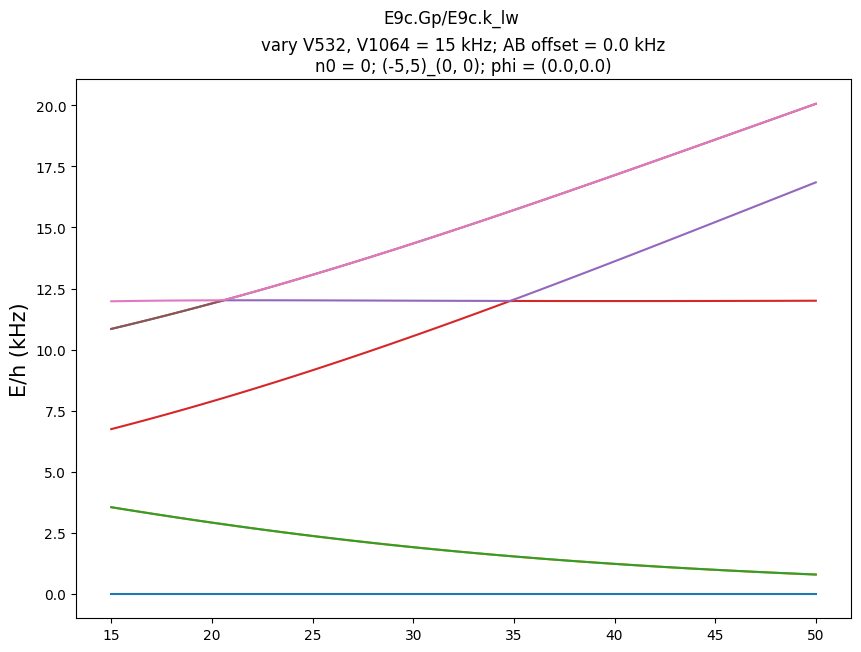

In [15]:
f2kHz = f_unit / 1e3 / (2 * np.pi) # conversion factor from natural units to kHz
E_lowest = np.min(e_values, axis = 1)  # lowest energy for each value of V532
fig_E = plt.figure(0, figsize=(10,7))
fig_E.clf()
fig_E.suptitle(Qp_str)

ax_E = fig_E.add_subplot(111)
ax_E.set_ylabel('E/h (kHz)', fontsize = 15)
for i in range(bandnum):
    ax_E.plot(V532nom, (e_values[:, i] - E_lowest) * f2kHz, '-', label = 'Non-interacting' + str(i + bandstart))

ax_E.set_title('vary V532, V1064 = {} kHz; AB offset = {:.4} kHz\nn0 = {}; (-{},{})_{}; phi = ({:.4},{:.4})'.format(V1064nom, float(ABoffset1064nom), n0nom, num, num, k_center, phi12, phi23))

In [12]:
e_values.shape

(100, 7)